In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

# Switch to parent path to import local module
os.chdir('/home/jupyter/Elton/Zeolites/zeosyn_gen/')
print('Switched directory to:', os.getcwd())

import data.utils as utils
sys.modules['utils'] = utils # Way to get around relative imports in utils for ZeoSynGen_dataset # https://stackoverflow.com/questions/2121874/python-pickling-after-changing-a-modules-directory

/home/synthesisproject/anaconda3/envs/zeo_diffusion_metrics_eq/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Switched directory to: /home/jupyter/Elton/Zeolites/zeosyn_gen


/home/synthesisproject/anaconda3/envs/zeo_diffusion_metrics_eq/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
true = pd.DataFrame()
true['Si/Al'] = [10., 14.3, 10., 10.]
true['sda1/Si'] = [0.15, 0.15, 0.35, 0.1]
true['Na/Si'] = [0.2, 0.2, 0.3, 0.2]
true['K/Si'] = [0., 0., 0., 0.]
true['H2O/Si'] = [15., 15., 15., 15.]
true['cryst_temp'] = [175., 175., 175., 175.]
true['cryst_time'] = [168., 168., 168., 168.]
true

,Si/Al,sda1/Si,Na/Si,K/Si,H2O/Si,cryst_temp,cryst_time
0,10.0,0.15,0.2,0.0,15.0,175.0,168.0
1,14.3,0.15,0.2,0.0,15.0,175.0,168.0
2,10.0,0.35,0.3,0.0,15.0,175.0,168.0
3,10.0,0.10,0.2,0.0,15.0,175.0,168.0


In [3]:
pred = pd.read_csv('predictions/UFI_C1COCCN2CCOCCOCCN(CCO1)CCOCCOCC2/syn_pred.csv')
pred = pred[pred['Si/Al'] > 0]

# Preprocess to unnormalized molar ratios
hets = ['Al', 'Ge', 'B']
thresholds = [0.00251, 0.099990, 0.004001]
for het, thres in zip(hets, thresholds):

    pred[f'{het}/Si'] = 1. / pred[f'Si/{het}']
    pred[f'{het}/Si'] = pred[f'{het}/Si'].map(lambda x: 1e-4 if x <= thres else x)
    pred[f'{het}'] = pred[f'{het}/Si']
    pred['Si'] = [1.]*len(pred)

tot_hets = pred[['Si']+hets].sum(1) # sum of heteroatoms fractions

for c in ['Na', 'K', 'OH', 'F', 'H2O', 'sda1']:
    pred[f'{c}'] = pred[f'{c}/T'] * tot_hets
    pred[f'{c}/Si'] = pred[f'{c}'] / pred['Si']

pred

,Si/Al,Al/P,Si/Ge,Si/B,Na/T,K/T,OH/T,F/T,H2O/T,sda1/T,...,K,K/Si,OH,OH/Si,F,F/Si,H2O,H2O/Si,sda1,sda1/Si
0,6.493506,1.717997,99.0,250.0,0.182112,0.022678,0.243520,0.0,14.705882,0.062500,...,0.026175,0.026175,0.281070,0.281070,0.0,0.0,16.973529,16.973529,0.072138,0.072138
5,7.783688,1.717997,99.0,250.0,0.200000,0.049615,0.199852,0.0,13.333333,0.041667,...,0.055999,0.055999,0.225568,0.225568,0.0,0.0,15.048984,15.048984,0.047029,0.047029
8,7.581384,1.717997,99.0,250.0,0.233551,0.000000,0.166667,0.0,16.169056,0.080440,...,0.000000,0.000000,0.188684,0.188684,0.0,0.0,18.305021,18.305021,0.091067,0.091067
9,6.493506,1.717997,99.0,250.0,0.230288,0.000000,0.250000,0.0,12.500000,0.072178,...,0.000000,0.000000,0.288550,0.288550,0.0,0.0,14.427500,14.427500,0.083308,0.083308
10,6.515651,1.717997,99.0,250.0,0.344796,0.000000,0.052608,0.0,12.500000,0.050000,...,0.000000,0.000000,0.060693,0.060693,0.0,0.0,14.420958,14.420958,0.057684,0.057684
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
992,7.109064,1.717997,99.0,250.0,0.330965,0.000000,0.000000,0.0,12.493381,0.050000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,14.253268,14.253268,0.057043,0.057043
995,6.493506,1.717997,99.0,250.0,0.287107,0.000000,0.196073,0.0,12.243384,0.083333,...,0.000000,0.000000,0.226307,0.226307,0.0,0.0,14.131314,14.131314,0.096183,0.096183
996,6.600000,1.717997,99.0,250.0,0.282658,0.000000,0.250000,0.0,13.031354,0.075000,...,0.000000,0.000000,0.287929,0.287929,0.0,0.0,15.008408,15.008408,0.086379,0.086379
998,6.600000,1.717997,99.0,250.0,0.296503,0.000000,0.149999,0.0,12.991538,0.064502,...,0.000000,0.000000,0.172756,0.172756,0.0,0.0,14.962551,14.962551,0.074288,0.074288


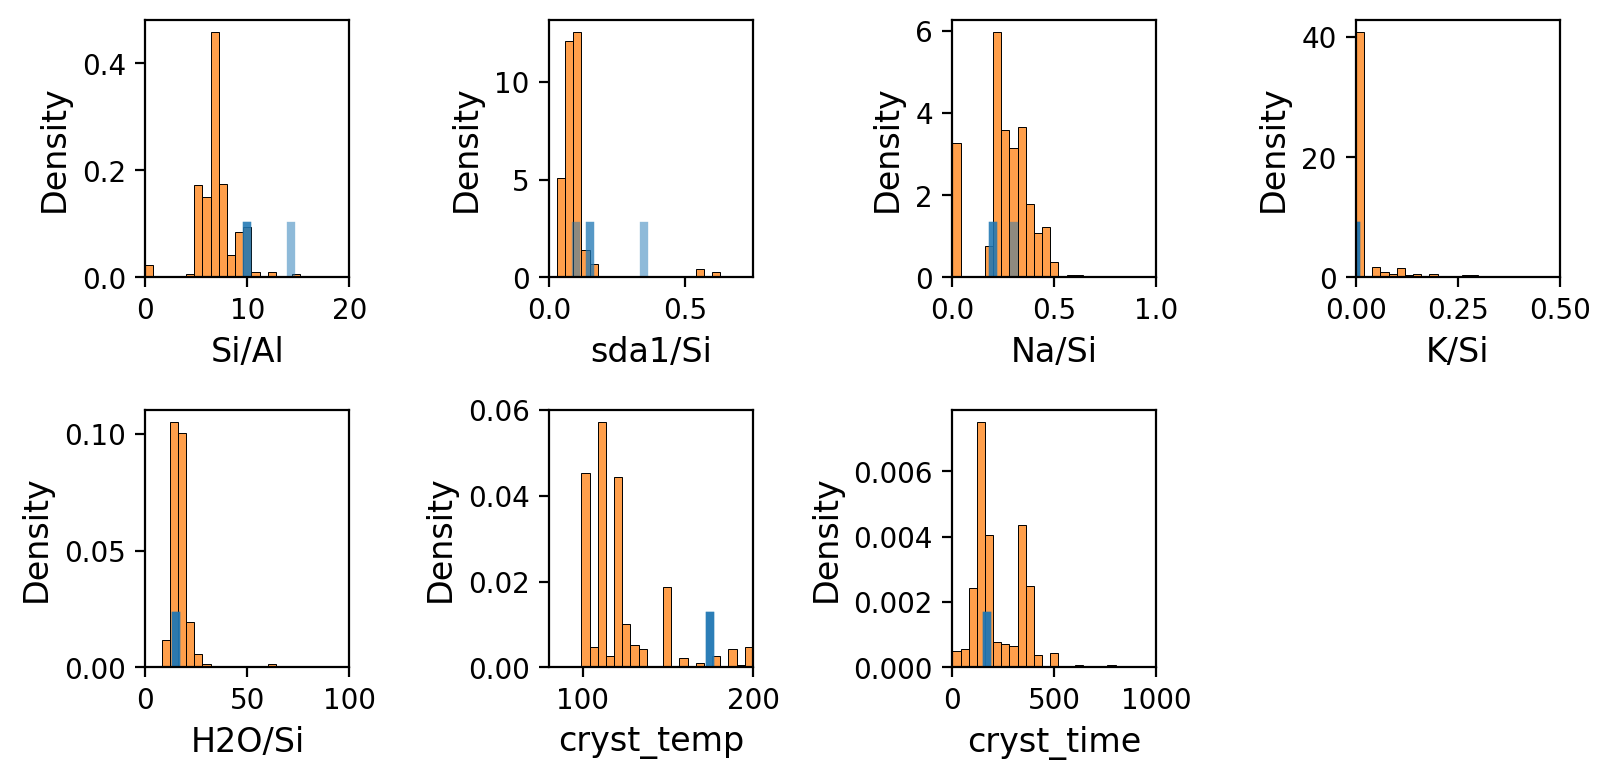

In [4]:
# Si/Al
col2spec = {'Si/Al': {'xlim': (0, 20)},
            'sda1/Si': {'xlim': (0, 0.75)},
            'Na/Si': {'xlim': (0, 1)},
            'K/Si': {'xlim': (0, 0.5)},
            'H2O/Si': {'xlim': (0, 100)},
            'cryst_temp': {'xlim': (80, 200)},
            'cryst_time': {'xlim': (0, 1000)},
            }

fig = plt.figure(figsize=(8, 4), dpi=200)

for i, col in enumerate(col2spec.keys()):
    ax = fig.add_subplot(2, 4, i+1)
    plot = sns.histplot(pred[col], color='tab:orange', label='Generated', 
                 binrange=col2spec[col]['xlim'], bins=25,
                 stat='density',
                #  kde=True, kde_kws={'bw_adjust': 0.5}
                 )
    ylim = plot.get_ylim()
    for v in true[col]:
        plt.plot([v, v], [0, 0.2 * ylim[-1]], color='tab:blue', linewidth=3, label='Experimental',
                 alpha=0.5
                 )
    plt.xlim(*col2spec[col]['xlim'])
# plt.legend()

plt.tight_layout()
plt.show()

In [5]:
pred

,Si/Al,Al/P,Si/Ge,Si/B,Na/T,K/T,OH/T,F/T,H2O/T,sda1/T,...,K,K/Si,OH,OH/Si,F,F/Si,H2O,H2O/Si,sda1,sda1/Si
0,6.493506,1.717997,99.0,250.0,0.182112,0.022678,0.243520,0.0,14.705882,0.062500,...,0.026175,0.026175,0.281070,0.281070,0.0,0.0,16.973529,16.973529,0.072138,0.072138
5,7.783688,1.717997,99.0,250.0,0.200000,0.049615,0.199852,0.0,13.333333,0.041667,...,0.055999,0.055999,0.225568,0.225568,0.0,0.0,15.048984,15.048984,0.047029,0.047029
8,7.581384,1.717997,99.0,250.0,0.233551,0.000000,0.166667,0.0,16.169056,0.080440,...,0.000000,0.000000,0.188684,0.188684,0.0,0.0,18.305021,18.305021,0.091067,0.091067
9,6.493506,1.717997,99.0,250.0,0.230288,0.000000,0.250000,0.0,12.500000,0.072178,...,0.000000,0.000000,0.288550,0.288550,0.0,0.0,14.427500,14.427500,0.083308,0.083308
10,6.515651,1.717997,99.0,250.0,0.344796,0.000000,0.052608,0.0,12.500000,0.050000,...,0.000000,0.000000,0.060693,0.060693,0.0,0.0,14.420958,14.420958,0.057684,0.057684
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
992,7.109064,1.717997,99.0,250.0,0.330965,0.000000,0.000000,0.0,12.493381,0.050000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,14.253268,14.253268,0.057043,0.057043
995,6.493506,1.717997,99.0,250.0,0.287107,0.000000,0.196073,0.0,12.243384,0.083333,...,0.000000,0.000000,0.226307,0.226307,0.0,0.0,14.131314,14.131314,0.096183,0.096183
996,6.600000,1.717997,99.0,250.0,0.282658,0.000000,0.250000,0.0,13.031354,0.075000,...,0.000000,0.000000,0.287929,0.287929,0.0,0.0,15.008408,15.008408,0.086379,0.086379
998,6.600000,1.717997,99.0,250.0,0.296503,0.000000,0.149999,0.0,12.991538,0.064502,...,0.000000,0.000000,0.172756,0.172756,0.0,0.0,14.962551,14.962551,0.074288,0.074288


In [6]:
with open(f'data/ZeoSynGen_dataset.pkl', 'rb') as f: # load dataset
    dataset = pickle.load(f)
lit = dataset.get_datapoints_by_index(dataset_idxs=range(len(dataset)), scaled=False, return_dataframe=True)[1]
lit = lit[lit['Si/Al'] > 0]

# Preprocess to unnormalized molar ratios
hets = ['Al', 'Ge', 'B']
thresholds = [0.00251, 0.099990, 0.004001]
for het, thres in zip(hets, thresholds):

    lit[f'{het}/Si'] = 1. / lit[f'Si/{het}']
    lit[f'{het}/Si'] = lit[f'{het}/Si'].map(lambda x: 1e-4 if x <= thres else x)
    lit[f'{het}'] = lit[f'{het}/Si']
    lit['Si'] = [1.]*len(lit)

tot_hets = lit[['Si']+hets].sum(1) # sum of heteroatoms fractions

for c in ['Na', 'K', 'OH', 'F', 'H2O', 'sda1']:
    lit[f'{c}'] = lit[f'{c}/T'] * tot_hets
    lit[f'{c}/Si'] = lit[f'{c}'] / lit['Si']

In [7]:
lit

,Si/Al,Al/P,Si/Ge,Si/B,Na/T,K/T,OH/T,F/T,H2O/T,sda1/T,...,K,K/Si,OH,OH/Si,F,F/Si,H2O,H2O/Si,sda1,sda1/Si
0,400.0,0.000000,99.0,250.0,0.0,0.05,0.250000,0.0,31.000006,0.200000,...,0.050015,0.050015,0.250075,0.250075,0.00000,0.00000,31.009306,31.009306,0.200060,0.200060
1,400.0,0.000000,99.0,250.0,0.0,0.00,0.000000,0.5,7.500000,0.500000,...,0.000000,0.000000,0.000000,0.000000,0.50015,0.50015,7.502250,7.502250,0.500150,0.500150
2,400.0,0.000000,99.0,250.0,0.0,0.12,0.270000,0.0,44.000000,0.150000,...,0.120036,0.120036,0.270081,0.270081,0.00000,0.00000,44.013200,44.013200,0.150045,0.150045
3,400.0,0.000000,99.0,250.0,0.0,0.00,0.000000,0.5,20.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.50015,0.50015,20.006000,20.006000,0.000000,0.000000
4,2.5,1.717997,99.0,250.0,0.0,0.00,2.285717,0.0,28.571430,1.142857,...,0.000000,0.000000,3.200461,3.200461,0.00000,0.00000,40.005718,40.005718,1.600229,1.600229
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23956,30.0,1.717997,99.0,250.0,0.0,0.00,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000
23957,40.0,1.717997,99.0,250.0,0.0,0.00,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000
23958,70.0,1.717997,99.0,250.0,0.0,0.00,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000
23959,100.0,1.717997,99.0,250.0,0.0,0.00,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000


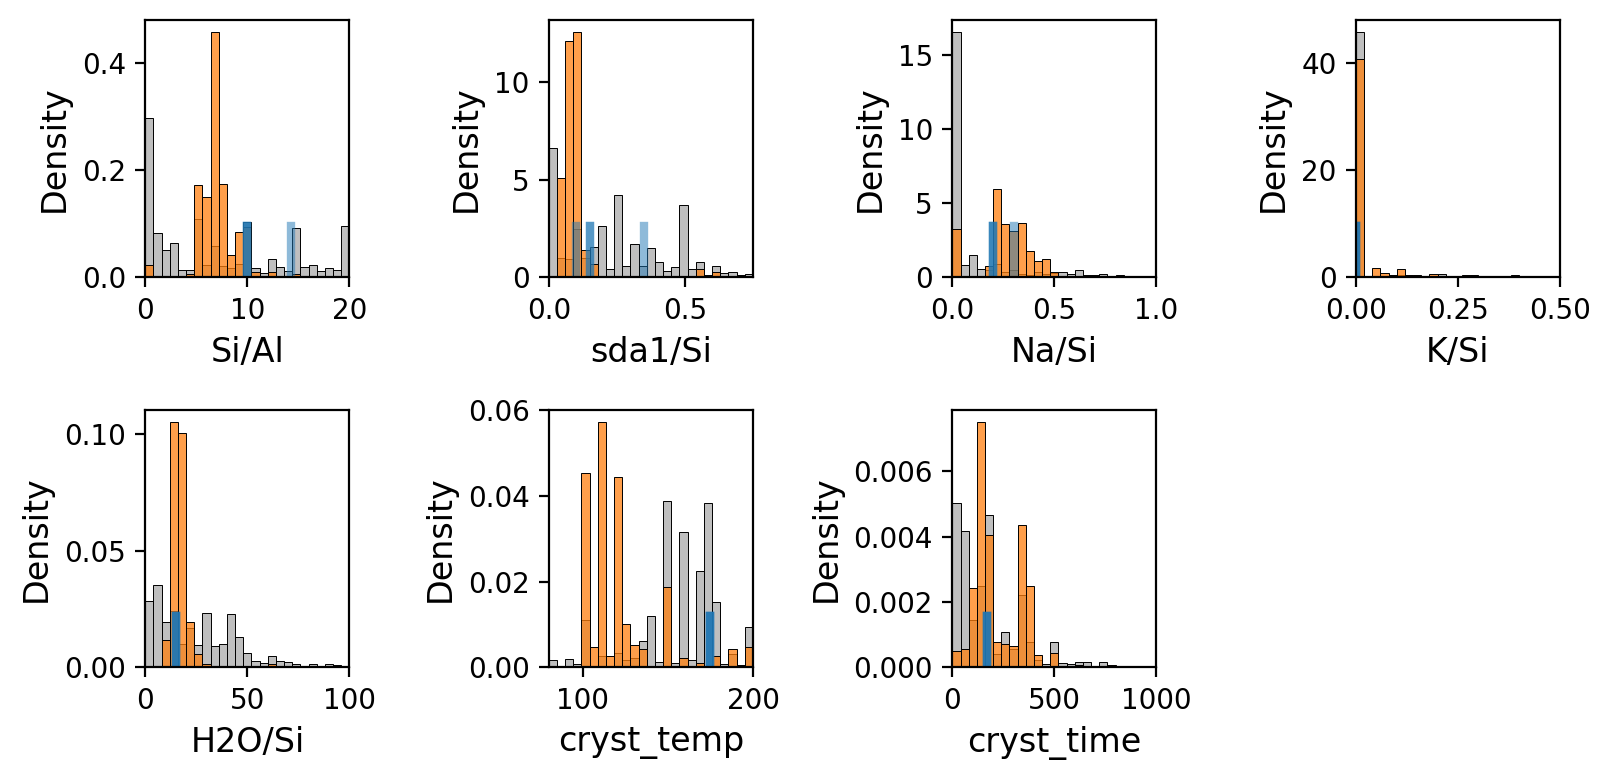

In [8]:
# Si/Al
col2spec = {'Si/Al': {'xlim': (0, 20)},
            'sda1/Si': {'xlim': (0, 0.75)},
            'Na/Si': {'xlim': (0, 1)},
            'K/Si': {'xlim': (0, 0.5)},
            'H2O/Si': {'xlim': (0, 100)},
            'cryst_temp': {'xlim': (80, 200)},
            'cryst_time': {'xlim': (0, 1000)},
            }

fig = plt.figure(figsize=(8, 4), dpi=200)

for i, col in enumerate(col2spec.keys()):
    ax = fig.add_subplot(2, 4, i+1)
    sns.histplot(lit[col], color='grey', label='Literature', 
                 binrange=col2spec[col]['xlim'], bins=25,
                 stat='density',
                 alpha=0.5
                #  kde=True, kde_kws={'bw_adjust': 0.5}
                 )
    plot = sns.histplot(pred[col], color='tab:orange', label='Generated', 
                 binrange=col2spec[col]['xlim'], bins=25,
                 stat='density',
                #  kde=True, kde_kws={'bw_adjust': 0.5}
                 )
    ylim = plot.get_ylim()
    for v in true[col]:
        plt.plot([v, v], [0, 0.2 * ylim[-1]], color='tab:blue', linewidth=3, label='Experimental',
                 alpha=0.5
                 )
    plt.xlim(*col2spec[col]['xlim'])
# plt.legend()

plt.tight_layout()
plt.show()

# PCA

In [9]:
true

,Si/Al,sda1/Si,Na/Si,K/Si,H2O/Si,cryst_temp,cryst_time
0,10.0,0.15,0.2,0.0,15.0,175.0,168.0
1,14.3,0.15,0.2,0.0,15.0,175.0,168.0
2,10.0,0.35,0.3,0.0,15.0,175.0,168.0
3,10.0,0.10,0.2,0.0,15.0,175.0,168.0


In [10]:
pred[col2spec.keys()]

,Si/Al,sda1/Si,Na/Si,K/Si,H2O/Si,cryst_temp,cryst_time
0,6.493506,0.072138,0.210194,0.026175,16.973529,100.00000,336.00000
5,7.783688,0.047029,0.225735,0.055999,15.048984,120.00000,144.00000
8,7.581384,0.091067,0.264403,0.000000,18.305021,120.00000,405.72330
9,6.493506,0.083308,0.265799,0.000000,14.427500,120.00000,144.00000
10,6.515651,0.057684,0.397783,0.000000,14.420958,125.00000,91.08633
...,...,...,...,...,...,...,...
992,7.109064,0.057043,0.377587,0.000000,14.253268,100.00000,216.00000
995,6.493506,0.096183,0.331379,0.000000,14.131314,105.26376,139.27500
996,6.600000,0.086379,0.325541,0.000000,15.008408,110.00000,168.00000
998,6.600000,0.074288,0.341487,0.000000,14.962551,120.00000,312.00000


In [11]:
lit[col2spec.keys()]

,Si/Al,sda1/Si,Na/Si,K/Si,H2O/Si,cryst_temp,cryst_time
0,400.0,0.200060,0.0,0.050015,31.009306,150.000000,504.000000
1,400.0,0.500150,0.0,0.000000,7.502250,175.000000,168.000000
2,400.0,0.150045,0.0,0.120036,44.013200,150.000000,144.000000
3,400.0,0.000000,0.0,0.000000,20.006000,115.720856,660.165100
4,2.5,1.600229,0.0,0.000000,40.005718,125.000000,72.000000
...,...,...,...,...,...,...,...
23956,30.0,0.000000,0.0,0.000000,0.000000,135.000000,558.916321
23957,40.0,0.000000,0.0,0.000000,0.000000,160.000000,240.032150
23958,70.0,0.000000,0.0,0.000000,0.000000,170.000000,53.891212
23959,100.0,0.000000,0.0,0.000000,0.000000,170.000000,193.911392


In [12]:
combined = pd.concat([true, pred[col2spec.keys()], lit[col2spec.keys()]], axis=0).reset_index(drop=True)
true_idx = np.arange(0, len(true))
pred_idx = np.arange(len(true), len(true)+len(pred))
lit_idx = np.arange(len(true)+len(pred), len(true)+len(pred)+len(lit))
combined

,Si/Al,sda1/Si,Na/Si,K/Si,H2O/Si,cryst_temp,cryst_time
0,10.000000,0.150000,0.200000,0.000000,15.000000,175.0,168.000000
1,14.300000,0.150000,0.200000,0.000000,15.000000,175.0,168.000000
2,10.000000,0.350000,0.300000,0.000000,15.000000,175.0,168.000000
3,10.000000,0.100000,0.200000,0.000000,15.000000,175.0,168.000000
4,6.493506,0.072138,0.210194,0.026175,16.973529,100.0,336.000000
...,...,...,...,...,...,...,...
20565,30.000000,0.000000,0.000000,0.000000,0.000000,135.0,558.916321
20566,40.000000,0.000000,0.000000,0.000000,0.000000,160.0,240.032150
20567,70.000000,0.000000,0.000000,0.000000,0.000000,170.0,53.891212
20568,100.000000,0.000000,0.000000,0.000000,0.000000,170.0,193.911392


In [13]:
X = combined

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=2, random_state=0)
# tsne = TSNE(n_components=2, init='random', perplexity=30)
X_pca = pca.fit_transform(X_scaled)
# X_tsne = tsne.fit_transform(X_scaled)
combined['PCA 1'] = X_pca[:, 0]
combined['PCA 2'] = X_pca[:, 1]
# combined['t-SNE 1'] = X_tsne[:, 0]
# combined['t-SNE 2'] = X_tsne[:, 1]
combined

,Si/Al,sda1/Si,Na/Si,K/Si,H2O/Si,cryst_temp,cryst_time,PCA 1,PCA 2
0,10.000000,0.150000,0.200000,0.000000,15.000000,175.0,168.000000,-0.131420,-0.171868
1,14.300000,0.150000,0.200000,0.000000,15.000000,175.0,168.000000,-0.134961,-0.158260
2,10.000000,0.350000,0.300000,0.000000,15.000000,175.0,168.000000,-0.039533,-0.175771
3,10.000000,0.100000,0.200000,0.000000,15.000000,175.0,168.000000,-0.140989,-0.176453
4,6.493506,0.072138,0.210194,0.026175,16.973529,100.0,336.000000,0.030997,-1.704734
...,...,...,...,...,...,...,...,...,...
20565,30.000000,0.000000,0.000000,0.000000,0.000000,135.0,558.916321,-0.305913,-0.793063
20566,40.000000,0.000000,0.000000,0.000000,0.000000,160.0,240.032150,-0.297231,-0.343156
20567,70.000000,0.000000,0.000000,0.000000,0.000000,170.0,53.891212,-0.299183,-0.099285
20568,100.000000,0.000000,0.000000,0.000000,0.000000,170.0,193.911392,-0.362093,0.039557


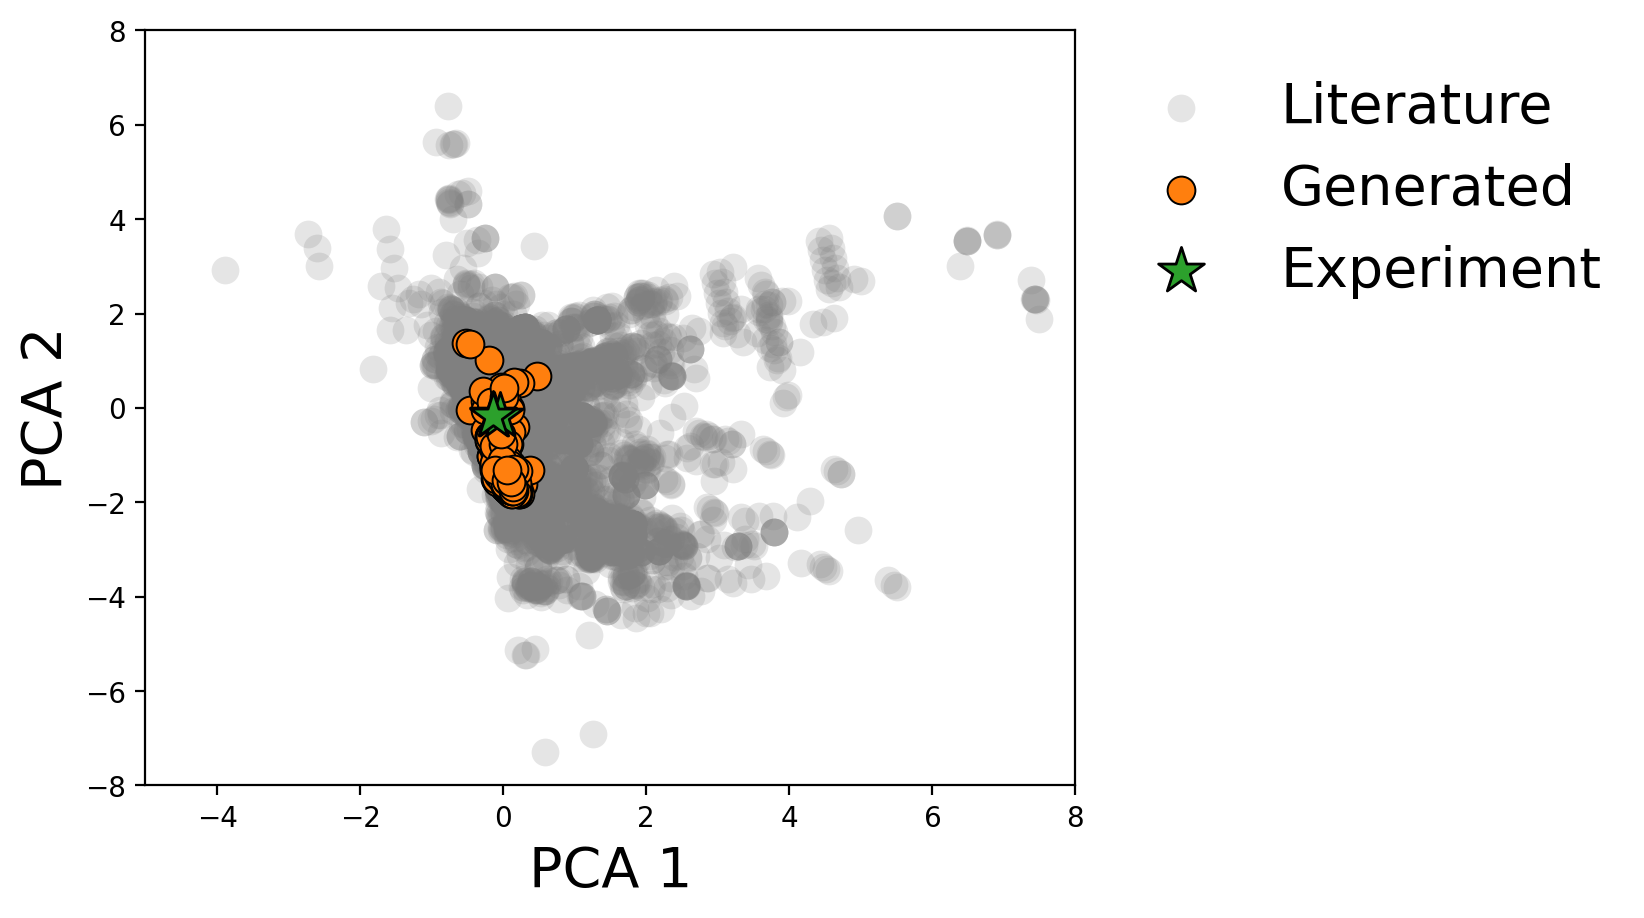

In [14]:
metric = 'PCA'
# metric = 't-SNE'

plt.figure(figsize=(6, 5), dpi=200)
plt.scatter(combined.iloc[lit_idx][f'{metric} 1'], combined.iloc[lit_idx][f'{metric} 2'], c='grey', label='Literature', marker='o', s=100, linewidth=0.,  edgecolor='black', alpha=0.2,
            )
plt.scatter(combined.iloc[pred_idx][f'{metric} 1'], combined.iloc[pred_idx][f'{metric} 2'], c='tab:orange', label='Generated', marker='o', s=100, linewidth=0.7,  edgecolor='black', alpha=1.,
            )
plt.scatter(combined.iloc[true_idx][f'{metric} 1'], combined.iloc[true_idx][f'{metric} 2'], c='tab:green', label='Experiment', marker='*', s=300, linewidth=1.,  edgecolor='black', alpha=1.,
            )
plt.xlabel(f'{metric} 1', fontsize=20)
plt.ylabel(f'{metric} 2', fontsize=20)
plt.xlim(-5, 8)
plt.ylim(-8, 8)
# plt.xlim(-2.5, 0.5)
# plt.ylim(-1, 1)
plt.legend(fontsize=20)
plt.show()